<a href="https://colab.research.google.com/github/facundograpsas/machine-learning/blob/main/end_to_end_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-ende Multi-class Dog breed Classification

This notebook builds an and-to-end multi-class image classifier using TensorFlow 2.0
and TansworFlow hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, i want to know what breed it is.

## 2. Data 

The data we're using is from Kaggle's dog breed identification competition.

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructued data) so it's probably we use deep learning/transfer learning
* There are 120 breeds of dogs(this means there are 120 different classes)
* There are around 10,000 images in the training set
(these images have labels)
* There are around 10.000 images in the test set 
(these images have no labels, because we'll want to predict them).

In [ ]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision"

## Get our workspace ready

* Import TensorFlow 2.X
* Import TensorFlow Hub
* Make sure we're using a GPU

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.2.0
TF Hub version: 0.8.0


In [ ]:
# Check for GPU availsability
print("GPU", "available (YEESSS!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YEESSS!!!)


## Getting our data ready (tuning into Tensors)

With all machine learning models, our data hast to be in numerical format. So that's what we'll be doing first. Turning our images into Tensor (numerical representations).

Let's start by accesing our data and checking out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     b4a8871365faccfa51e33217c4fd1291  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


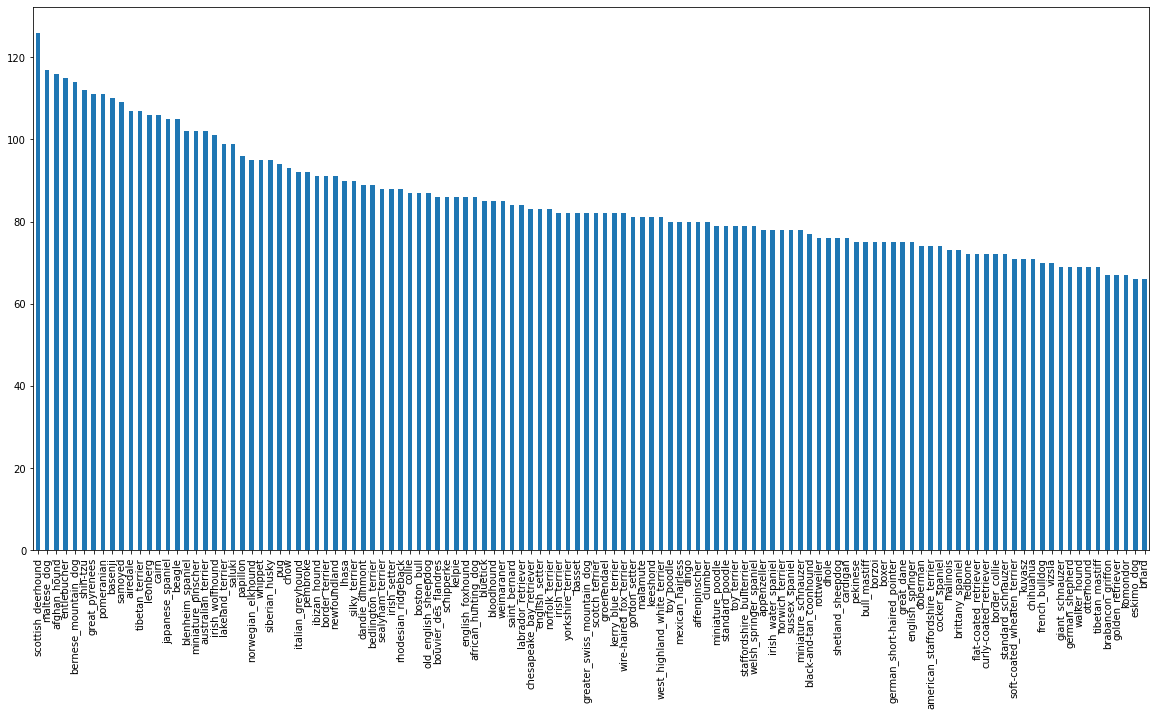

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

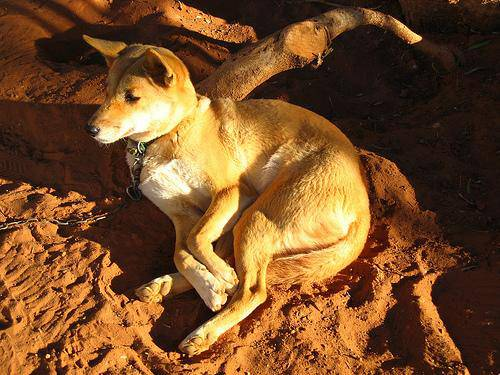

In [ ]:
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image files pathnames.

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create pathnames from images ID's
filenames = ["drive/My Drive/Dog Vision/train/"+fname for fname in labels_csv["id"]+".jpg"]

#Ck theche first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check wheter number of filenames matches number of actual images files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual amount of files.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files.


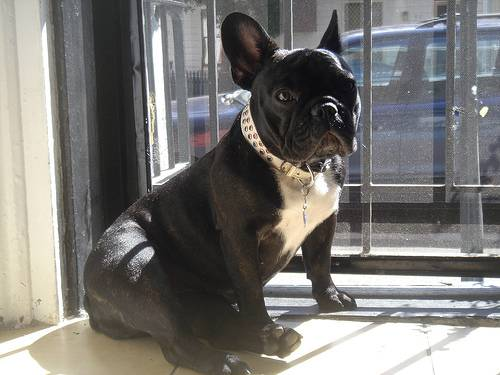

In [ ]:
# One more check
Image(filenames[6543])

In [ ]:
labels_csv["breed"][6543]

'french_bulldog'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")
  

Number of labels matches number of filenames


In [ ]:
# Fin the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]
boolean_labels[2]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) #i index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation, we're going to create our own

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

We're goig to start off experiment with 1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                  test_size=0.2, random_state=42)

In [ ]:
len(X_train),len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable,` image`
3. Turn our `image` into Tensors
4. Resize the `image` to be a shape of (224,224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread

image = imread( filenames[42])
image.shape

(257, 350, 3)

In [ ]:
%time
image.max(), image.min()


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


(255, 0)

In [ ]:
# Turn image into a Tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-255 to 0-1 values (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224) 
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turning our data into batches

Why turn our data into batches?

Let's you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time.

In order to user TensorFlow effectively, we need ur data in the form of Tensor tuples wich look like this:
`(image, label)`

In [ ]:
# Create a simple function to return a tuple (image,label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label, processes the image and return a tuple of()image,label.
  """
  image = process_image(image_path)
  return image,label

In [ ]:
(get_image_label(X[42], y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image,label)`, let's make a function to turn all of our data into batches

In [ ]:
print(tf.data.Dataset.from_tensor_slices((X)))

<TensorSliceDataset shapes: (), types: tf.string>


In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((X, # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepath and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                             tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is fsater than shuffling images.
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the training data into batches 
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [ ]:
%time
len(X)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.48 µs


10222

In [ ]:
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data is now in batches, however, these can be a little hard to understand, let's visualize them.

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(15,15))
  # Loop through 25
  for i in range(25):
    ax = plt.subplot(5,5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")


In [ ]:
len(train_images), len(train_labels)

NameError: ignored

In [ ]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The url of the model we want to use.

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE,3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model.

All of this step can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Creates a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url= MODEL_URL):
  print("Building model with:",MODEL_URL)

  # Setup te model layers

  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation = "softmax") # Layer 2 (output layer)
                               ])
  
  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  #Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its prorgess, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model `fit()` function.
3. Visualize or models training logs with the `%tensorboard` magic function (we'll do this after model training)


In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard log
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.



In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.


In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10,max:100,step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "Available") if tf.config.list_physical_devices("GPU") else "not available"

Let's create a function which trains a model.

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback`
* Call the `fit` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the mode to the data passing it the callbacks we created
  model.fit( x=train_data, 
            epochs=NUM_EPOCHS, 
            validation_data=val_data, 
            validation_freq=1,
            callbacks = [tensorboard, early_stopping])
  return model

In [ ]:
#Fit the model to the data
model = train_model()

Mode is overfitting in the training set, we have to find a way to prevent this.

**Note:** Overfitting to begin with is a good thing. It means the model is learning

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs


 ## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

In [ ]:
predictions.shape

In [ ]:
len(y_val)

In [ ]:
np.sum(predictions[0])

In [ ]:
np.sum(predictions[1])

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction):{np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index:{np.argmax(predictions[index])}")
print(f"Predicted label:{unique_breeds[np.argmax(predictions[index])]}")

Having the above functionality is great but we want to be able to do it at scale.

And it would be event better if we could see the image prediction is being made on.

**Note:** Predictions probabilities are also known as confidence levels.

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[10])
pred_label

In [ ]:
val_data 

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and the compare those predictions to the validations labels(truth labels).

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []

  for image, label in batch.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

get_pred_label(val_labels[0])

In [ ]:
get_pred_label(predictions[5])

In [ ]:
get_pred_label(labels_[5])

Now we've got ways to get:
* Predictions labels
* Validation labels (truth labels)
* Validation images
Let's make some function to make these all a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n],images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images,n=171)

Now we've got one function to visuaize our models top prediction, let0s make another to view our models top 10 predictions:

* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
 * Prediction probabilities indexes
 * Prediction probabilities values
 * Prediction labels
* Plot the top 10 predictions values and labels, coloring the true label green


In [ ]:
def plot_pred_conf(prediction_probabilities,labels, n=1):
  """
  Plus the top 10 highest prediction confidences along witht eh truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
                           rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label,top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=50)

In [ ]:
predictions[0].argsort()[-10:][::-1]

Now we've got some function to help us visualize our predictions and evaluate our mode, let's check out a few

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 50
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities = predictions,
            labels = val_labels,
            images = val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  
  plt.tight_layout(h_pad=1.0)
  
plt.show()


##Saving and reloading a trained model

In [ ]:
# Create a function to save a model

def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """

  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%m%s"))
  
  model_path = modeldir + "-" + suffix + ".h5" #save format of model
  print(f"Saving model to:{model_path}...")
  model.save(model_path)
  return model_path




In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a save model from a specified path
  """
  print(f"Loading saved model from:{model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model


Now we've got functions to save and load a trained model, let's make sure they work

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model("/content/drive/My Drive/Dog Vision/models/20200615-22061592260182-1000-images-mobilenetv2-Adam.h5")

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

In [ ]:
loaded_1000_image_model.evaluate(val_data)

### Training a big dog model (on the full data)

In [ ]:
len(X), len(y)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

In [ ]:
full_data

In [ ]:
# Create a model fur full model
full_model = create_model()

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=4)

**Note:** Running the cell below will take a little while
(maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

In [ ]:
save_model(full_model,suffix="full-image-set-mobilenetv2-Adam")

In [ ]:
loaded_full_model = load_model("/content/drive/My Drive/Dog Vision/models/20200616-00061592268201-full-image-set-mobilenetv2-Adam.h5")

## Making predictions on the test dataset

Since our model has been trained on imagesin the form of Tensor batches, to mkae predictions on the test data, we'll have to get it into the same format.

Luckily we created 'create_data_batches()' earlier which can take a list of filenaems as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using 
'create_data_batches()' and seting the 'test_data' parameter to True(since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the predict() method called on our model. 


In [ ]:
#Load testimage filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

In [ ]:
test_data

**Note:** Calling `predict()` on our full mode and passing it the test data batch will take a long time to run (about an 1hr)

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose = 1)

In [ ]:
# Save predictions (Numpy array)  to csv_file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv",test_predictions, delimiter=",")

In [ ]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

In [ ]:
test_predictions.shape

## Preparing test dataset to kaggle 

Looking at the Kaggle sample submission, we find that it wants our models predictions probability outputs in a DataFrame with and ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to th ID column by extracting the test image ID's frm their filepaths
* Add data (the prediction probabilities) to each of the dog breed column
* Export the DataFrame as a CSV to submit it to Kaggle.
 

In [ ]:
# Create a pandas DataFrame with empy columns
preds_df = pd.DataFrame(columns=["id"]+ list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:10]

In [ ]:
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df

In [ ]:
test_predictions.shape

In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mibilenetV2.csv", index=False)

## Making predictions on custom images
To make predictions on custom images, we'll:
* Get the filepath of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our customimages won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()`method.
* Convert the prediction output probabilities to predictions labels
* Compare the predicted labels to the custom images.


In [ ]:
# Get custsom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path+fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

In [ ]:
# Turn custum images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
custom_preds.shape

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
#Loop thorugh unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom images predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)